In [13]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
df = pd.read_csv('data/train.csv', low_memory=False)

In [6]:
df = df.drop(columns = 'Unnamed: 0')

In [7]:
df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,StateHoliday_a,StateHoliday_b,StateHoliday_c,...,Is_Weekend,Month,Year,Day,Day_of_Year,Is_Beginning_Month,Is_Mid_Month,Is_End_Month,Days_to_Holiday,Days_After_Holiday
0,1,5,-0.132683,-0.168269,1.0,1.0,1.0,True,False,False,...,0.0,7.0,2015.0,31.0,0.489328,0.0,0.0,1.0,0.191749,0.191749
1,2,5,0.075373,-0.017540,1.0,1.0,1.0,True,False,False,...,0.0,7.0,2015.0,31.0,0.489328,0.0,0.0,1.0,0.191749,0.191749
2,3,5,0.659800,0.404499,1.0,1.0,1.0,True,False,False,...,0.0,7.0,2015.0,31.0,0.489328,0.0,0.0,1.0,0.191749,0.191749
3,4,5,2.135414,1.862258,1.0,1.0,1.0,True,False,False,...,0.0,7.0,2015.0,31.0,0.489328,0.0,0.0,1.0,0.191749,0.191749
4,5,5,-0.247231,-0.159656,1.0,1.0,1.0,True,False,False,...,0.0,7.0,2015.0,31.0,0.489328,0.0,0.0,1.0,0.191749,0.191749


In [8]:

# Check for stationarity
result = adfuller(df['Sales'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    df['Sales_diff'] = df['Sales'].diff().dropna()
else:
    df['Sales_diff'] = df['Sales']


ADF Statistic: -5.274204515488962
p-value: 6.19114255959025e-06


#### Hypotheses of the ADF Test:
**Null Hypothesis (H₀)**: The time series has a unit root (it is non-stationary). <br>
**Alternative Hypothesis (H₁)**: The time series does not have a unit root (it is stationary).<br>
**Decision Rule**:<br>
If the **p-value ≤ 0.05**: Reject the null hypothesis. The data is stationary.<br>
If the **p-value > 0.05**: Fail to reject the null hypothesis. The data is non-stationary.

In my Case:
ADF Statistic: -5.27

p-value: 6.19×10−6(0.00000619)

Since the **p-value is much smaller than 0.05**, you can **reject the null hypothesis**.

This indicates that the time series data is stationary.

#### **No Differencing Needed**:
Because the data is already stationary, its does not need to apply differencing. <br>
In this case proceed with further steps like **autocorrelation analysis**, **creating lagged features**, and **building the LSTM model** directly.

# **Autocorrelation and Partial Autocorrelation**

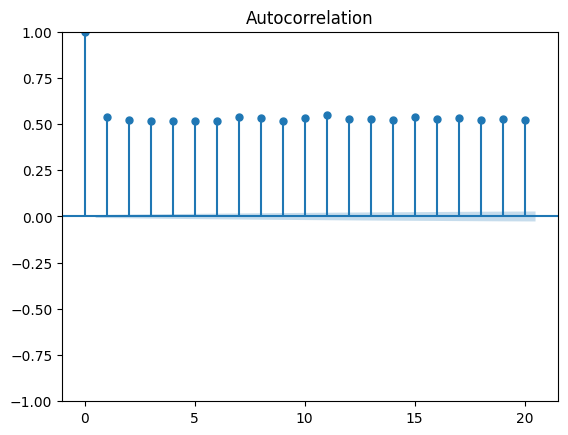

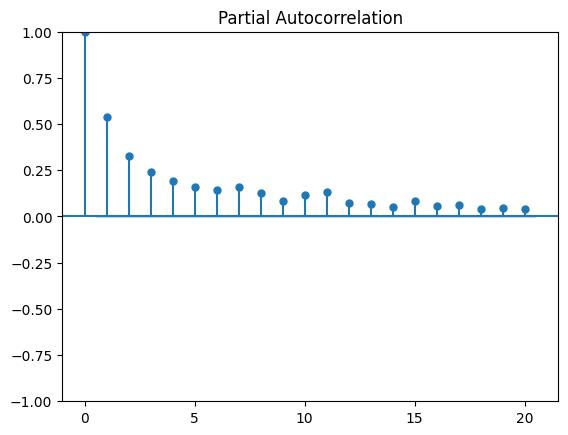

In [9]:
# Plot ACF and PACF
plot_acf(df['Sales_diff'].dropna(), lags=20)
plot_pacf(df['Sales_diff'].dropna(), lags=20)
plt.show()


# **Transform Data into Supervised Learning Format**

In [10]:


# Create lag features
def create_supervised_data(series, n_lags=5):
    X, y = [], []
    for i in range(len(series) - n_lags):
        X.append(series[i:i + n_lags])
        y.append(series[i + n_lags])
    return np.array(X), np.array(y)

# Scale data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_sales = scaler.fit_transform(df['Sales_diff'].values.reshape(-1, 1)).flatten()

# Prepare supervised data
n_lags = 10
X, y = create_supervised_data(scaled_sales, n_lags)


# **Build an LSTM Model**

In [11]:
# Reshape data for LSTM (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(n_lags, 1), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=20, batch_size=32, verbose=2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1906/1906 - 10s - 5ms/step - loss: 0.0191
Epoch 2/20
1906/1906 - 9s - 5ms/step - loss: 0.0164
Epoch 3/20
1906/1906 - 10s - 5ms/step - loss: 0.0163
Epoch 4/20
1906/1906 - 6s - 3ms/step - loss: 0.0162
Epoch 5/20
1906/1906 - 7s - 3ms/step - loss: 0.0162
Epoch 6/20
1906/1906 - 6s - 3ms/step - loss: 0.0160
Epoch 7/20
1906/1906 - 8s - 4ms/step - loss: 0.0160
Epoch 8/20
1906/1906 - 9s - 5ms/step - loss: 0.0159
Epoch 9/20
1906/1906 - 10s - 5ms/step - loss: 0.0158
Epoch 10/20
1906/1906 - 11s - 6ms/step - loss: 0.0158
Epoch 11/20
1906/1906 - 6s - 3ms/step - loss: 0.0157
Epoch 12/20
1906/1906 - 11s - 6ms/step - loss: 0.0156
Epoch 13/20
1906/1906 - 9s - 5ms/step - loss: 0.0155
Epoch 14/20
1906/1906 - 11s - 6ms/step - loss: 0.0154
Epoch 15/20
1906/1906 - 10s - 5ms/step - loss: 0.0153
Epoch 16/20
1906/1906 - 6s - 3ms/step - loss: 0.0153
Epoch 17/20
1906/1906 - 7s - 4ms/step - loss: 0.0152
Epoch 18/20
1906/1906 - 7s - 4ms/step - loss: 0.0152
Epoch 19/20
1906/1906 - 9s - 5ms/step - loss: 0.

In [14]:
# Build the LSTM model
model = Sequential([
    Input(shape=(n_lags, 1)),  # Define input shape explicitly
    LSTM(50, activation='relu', return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, y, epochs=20, batch_size=32, verbose=2)

Epoch 1/20
1906/1906 - 9s - 5ms/step - loss: 0.0212
Epoch 2/20
1906/1906 - 7s - 4ms/step - loss: 0.0164
Epoch 3/20
1906/1906 - 10s - 5ms/step - loss: 0.0163
Epoch 4/20
1906/1906 - 7s - 3ms/step - loss: 0.0162
Epoch 5/20
1906/1906 - 6s - 3ms/step - loss: 0.0162
Epoch 6/20
1906/1906 - 10s - 5ms/step - loss: 0.0161
Epoch 7/20
1906/1906 - 10s - 5ms/step - loss: 0.0160
Epoch 8/20
1906/1906 - 6s - 3ms/step - loss: 0.0160
Epoch 9/20
1906/1906 - 6s - 3ms/step - loss: 0.0159
Epoch 10/20
1906/1906 - 6s - 3ms/step - loss: 0.0158
Epoch 11/20
1906/1906 - 10s - 5ms/step - loss: 0.0157
Epoch 12/20
1906/1906 - 10s - 5ms/step - loss: 0.0156
Epoch 13/20
1906/1906 - 11s - 6ms/step - loss: 0.0155
Epoch 14/20
1906/1906 - 6s - 3ms/step - loss: 0.0155
Epoch 15/20
1906/1906 - 7s - 3ms/step - loss: 0.0154
Epoch 16/20
1906/1906 - 6s - 3ms/step - loss: 0.0153
Epoch 17/20
1906/1906 - 10s - 5ms/step - loss: 0.0152
Epoch 18/20
1906/1906 - 7s - 3ms/step - loss: 0.0151
Epoch 19/20
1906/1906 - 6s - 3ms/step - loss: 0.

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 10, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

# **Save the Trained Model**

In [17]:
import pickle

# Save the model using pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)


In [20]:
# Load the model using pickle
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)



# **Future Sales Prediction**

In [23]:
# Load the model
model = None
with open('model.pkl', 'rb') as file:
    model = pickle.load(file)

# Make predictions
new_data = scaled_sales[-n_lags:]  # Take the last n_lags data points
new_data = new_data.reshape((1, n_lags, 1))
predicted_sales = model.predict(new_data)

# Reverse scaling
predicted_sales_original = scaler.inverse_transform(predicted_sales)
print(f'Predicted Sales: {predicted_sales_original.flatten()[0]}')


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
Predicted Sales: -1.4510443210601807
